# 可视化高维特征空间中的数据点分布。

在文章"A"的5.2.3节中，标题为"What is the relationship among architectural styles?"，作者使用了特征可视化来解释模型学到的关于年龄信息和建筑风格之间的关系。具体来说，每个图像样本的深度特征向量从模型中获得，并使用t-SNE投影到二维平面上。在图11中，颜色表示每个点所属的年龄组。投影的点自动形成9个具有清晰边界的簇。深色代表早期年代，浅色表示近期年代。


![](../../assets/图11_每幅图像的深层特征被投影到二维平面上_以了解模型对建筑物年龄的了解.jpg)

为了实现这一部分，我们分为下面散步：
- 提取深度特征：使用预训练的模型，为每个图像样本提取深度特征。
- t-SNE降维：使用t-SNE算法将高维特征降维到二维平面。
- 可视化：使用matplotlib或其他可视化库在二维平面上绘制t-SNE结果。

## 1.加载模型，提取深度特征

In [2]:
### 1.读取图片文件并分割出测试集数据

# 重新加载
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


### 3.自定义加载dataset并加载

# 我们需要进一步修改CustomDataset类以返回文件名中的建筑id。然后，在预测循环中收集文件名，并在所有预测完成后将它们与预测结果一起保存到CSV文件中。以下是如何实现它的步骤：

class CustomDataset(Dataset):
    """包装PyTorch数据集以应用转换。"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.imgs = subset.dataset.imgs

    def __getitem__(self, index):
        img, y = self.subset[index] # 这里的y是类别的索引
        
        # 获取文件名
        file_name = self.imgs[self.subset.indices[index]][0]  # 修改这里以匹配您的文件名和路径结构
        # 获取文件名中的id
        id = file_name.split('--')[-2]
        
        if self.transform:
            img = self.transform(img)

        return img, y, id

    def __len__(self):
        return len(self.subset)

# 当使用t-SNE进行特征可视化时，最常用的做法是选择模型中的最后一个全连接层之前的输出作为特征。
# Densenst121应该在BatchNorm2d (norm5)之后、Linear (classifier)之前提取特征。
# 具体地说，应该提取BatchNorm2d (norm5)层的输出作为特征。
# 从模型summary的特征上看，BatchNorm2d (norm5)层将输出一个形状为[32, 1024, 9, 9]的特征张量，但通常我们会进行平均池化或者直接reshape来将其转换为[32, 1024]的二维张量，
# 然后再用这些特征进行t-SNE可视化。
class FeatureExtractor(torch.nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__() # 调用FeatureExtractor类的父类（torch.nn.Module）的构造函数，以确保所有基础功能都被正确初始化。
        # 获取到BatchNorm2d (norm5)层的所有层
        self.features = torch.nn.Sequential(*list(original_model.children())[:-1]) # 从原始模型original_model中提取除最后一层外的所有层
        # original_model.children(): 这会返回一个迭代器，包含original_model的所有直接子模块。在许多情况下，例如当使用预训练的模型时，这些子模块通常是网络的主要层或层组。
        # list(original_model.children()): 这将迭代器转换为一个列表，这样我们就可以对其进行索引和切片。
        # list(original_model.children())[:-1]: 通过这种方式进行切片，我们可以获得除最后一层外的所有层。假设original_model是一个预训练的分类网络，最后一层可能是一个全连接层，用于输出类别分数。通过排除这一层，我们可以得到一个仅进行特征提取的模型。
        # torch.nn.Sequential(*...): 这创建了一个新的Sequential模块，它包含我们从original_model中提取出来的所有层。*操作符是Python中的解包操作符，它将列表中的所有项解包并传递给Sequential构造函数。
    def forward(self, x):
        x = self.features(x)
        # 对空间维度进行平均池化
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return x


if __name__ == '__main__': # 以尝试将启动训练过程的代码放入此保护块中。这有助于防止 multiprocessing 在它不应该这样做的时候启动新进程。
    img_root =  "../../data/GSV/clip"  # '/root/autodl-tmp/GSV/clip' 
    all_data = datasets.ImageFolder(root=img_root)  # 不要应用tranform
    # 拆分数据
    train_size = int(0.8 * len(all_data))
    test_size = len(all_data) - train_size
    # 固定随机种子
    torch.manual_seed(8)
    train_data_raw, test_data_raw = random_split(all_data, [train_size, test_size])

    len(test_data_raw)

    ### 2.获取类名列表

    class_names = all_data.classes

    # 数据集的类别的字典形式
    class_dict = all_data.class_to_idx
    print(class_dict)
    
    ### 4.定义transform并加载测试集

    # 只需要调整尺寸和转换为张量
    test_transform = transforms.Compose([
            transforms.Resize(size=(300, 300), antialias=True), 
            transforms.ToTensor()

        ])

    test_data = CustomDataset(test_data_raw, transform=test_transform)

    ### 5.加载模型

    from torchvision.models import densenet121
    from torchvision.models.densenet import DenseNet121_Weights
    import torch
    import torch.nn as nn

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 加载预训练的DenseNet121模型
    model = densenet121(weights=DenseNet121_Weights.DEFAULT)

    ## 修改最后一层的输出特征数
    num_features = model.classifier.in_features
    # 修改为9个类别的输出特征数
    model.classifier = nn.Linear(num_features, 9)


    # 加载建筑年代的数据集
    model_path = '../models/weights_6/model_epoch_32.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))

    # 调整到eval评估模式
    model.eval()

    model.to(device)

    # 创建DataLoader 
    BATCH_SIZE = 32
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 
    # test_data_iter = iter(test_loader)
    # test_samples, test_labels, ids = next(test_data_iter) # next() 函数是用来获取迭代器的下一个批次的数据
    # print(test_samples.shape, test_labels.shape, len(ids) )
    
    # 6.进行预测并且提取深度特征
    # 提取特征
    features_list = []
    labels_list = []
    ids_list = []
    
    with torch.inference_mode():
        for inputs, labels, ids in tqdm(test_loader, desc="Predicting"): # 遍历test_loader会使用__getitem__方法,返回img, y, id
            # 转移到gpu 
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 收集图像ID
            ids_list.extend(ids)

            # 提取特征
            feature_extractor = FeatureExtractor(model).to(device)
            features = feature_extractor(inputs)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    # 使用np.concatenate将所有batch的特征和标签连接成一个大的Numpy数组。
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

{'1653–1705': 0, '1706–1764': 1, '1765–1845': 2, '1846–1910': 3, '1911–1943': 4, '1944–1977': 5, '1978–1994': 6, '1995–2023': 7, 'pre-1652': 8}


Predicting: 100%|██████████| 498/498 [06:48<00:00,  1.22it/s]


In [12]:
features_array, labels_array

(array([[-3.3858320e-04, -8.3478144e-04,  1.3391395e-03, ...,
         -9.7805464e-01,  3.2406225e+00,  1.8602258e+00],
        [ 2.5889723e-04, -3.0480269e-03, -1.9219483e-03, ...,
          3.7266250e+00,  2.5063151e-01, -2.2517569e-01],
        [-8.5119478e-05, -4.7685970e-03, -1.0739362e-04, ...,
          1.3678868e+00,  8.6307651e-01,  2.6941624e+00],
        ...,
        [ 6.8167370e-05, -4.1313731e-04, -3.4486810e-03, ...,
          3.3109493e+00,  2.0470252e+00, -2.5454009e-01],
        [ 2.0999328e-04,  2.2237210e-03, -4.8877863e-04, ...,
          1.8082867e+00,  1.5116850e+00,  4.0322712e-01],
        [-1.0900942e-04, -2.3988745e-04,  1.7320967e-03, ...,
         -3.3820558e-01,  8.9092419e-02, -2.0493454e-01]], dtype=float32),
 array([7, 7, 5, 4, 4, 4, 2, 0], dtype=int64))

In [34]:
# 使用t-SNE降维
tsne = TSNE(n_components=2, random_state=42) # , perplexity=5
transformed_features = tsne.fit_transform(features_array)

In [35]:
tsne

TSNE(random_state=42)

In [36]:
transformed_features

array([[ 26.825716 , -30.506935 ],
       [ 22.68087  ,  13.102355 ],
       [ -0.4206577, -72.070244 ],
       ...,
       [  3.5727541, -13.994683 ],
       [-55.486397 ,  13.2591715],
       [-47.20952  , -39.01483  ]], dtype=float32)

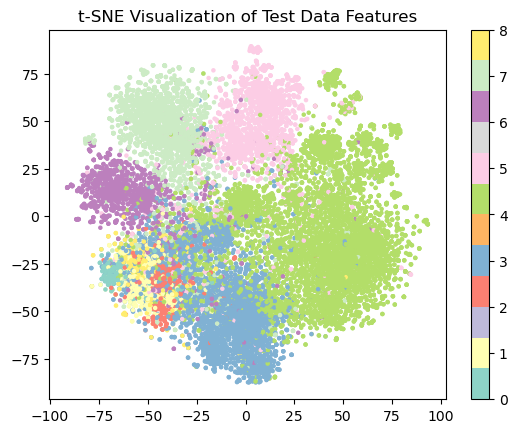

In [37]:
# 可视化
plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=labels_array, cmap='Set3', s=5) 
plt.colorbar()
plt.title("t-SNE Visualization of Test Data Features")
plt.show()

In [33]:
# 太丑了。导出绘图
transformed_features

array([[ 23.184633  , -26.00307   ],
       [ 35.400917  ,  21.843204  ],
       [-10.806614  , -90.15529   ],
       ...,
       [ -0.82847095, -22.713137  ],
       [-58.235386  ,   9.692378  ],
       [-60.45297   , -54.031307  ]], dtype=float32)

In [43]:
transformed_features.shape

(15907, 2)

In [41]:
labels

tensor([4, 6, 6], device='cuda:0')

In [45]:
print(len(transformed_features[:, 0]))
print(len(transformed_features[:, 1]))
print(len(labels_array))

15907
15907
15907


In [47]:
dict = {0: '1653–1705',
 1: '1706–1764',
 2: '1765–1845',
 3: '1846–1910',
 4: '1911–1943',
 5: '1944–1977',
 6: '1978–1994',
 7: '1995–2023',
 8: 'pre-1652'}
# 更换一下标签
# 使用vectorize函数替换labels_array中的值
vfunc = np.vectorize(dict.get)
labels_updated = vfunc(labels_array)
labels_updated

array(['1846–1910', '1911–1943', '1846–1910', ..., '1911–1943',
       '1978–1994', '1978–1994'], dtype='<U9')

In [48]:
import pandas as pd
pd.DataFrame({'1-t':transformed_features[:, 0],
              '2-t':transformed_features[:, 1],
              'label': labels_updated,
              'id': ids_list
}).to_csv('../../data/output/TSNE-output-on-test-datasets.csv', index=False)

## 在训练集的TSNE表现

In [49]:
### 1.读取图片文件并分割出测试集数据

# 重新加载
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


### 3.自定义加载dataset并加载

# 我们需要进一步修改CustomDataset类以返回文件名中的建筑id。然后，在预测循环中收集文件名，并在所有预测完成后将它们与预测结果一起保存到CSV文件中。以下是如何实现它的步骤：

class CustomDataset(Dataset):
    """包装PyTorch数据集以应用转换。"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.imgs = subset.dataset.imgs

    def __getitem__(self, index):
        img, y = self.subset[index] # 这里的y是类别的索引
        
        # 获取文件名
        file_name = self.imgs[self.subset.indices[index]][0]  # 修改这里以匹配您的文件名和路径结构
        # 获取文件名中的id
        id = file_name.split('--')[-2]
        
        if self.transform:
            img = self.transform(img)

        return img, y, id

    def __len__(self):
        return len(self.subset)

# 当使用t-SNE进行特征可视化时，最常用的做法是选择模型中的最后一个全连接层之前的输出作为特征。
# Densenst121应该在BatchNorm2d (norm5)之后、Linear (classifier)之前提取特征。
# 具体地说，应该提取BatchNorm2d (norm5)层的输出作为特征。
# 从模型summary的特征上看，BatchNorm2d (norm5)层将输出一个形状为[32, 1024, 9, 9]的特征张量，但通常我们会进行平均池化或者直接reshape来将其转换为[32, 1024]的二维张量，
# 然后再用这些特征进行t-SNE可视化。
class FeatureExtractor(torch.nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__() # 调用FeatureExtractor类的父类（torch.nn.Module）的构造函数，以确保所有基础功能都被正确初始化。
        # 获取到BatchNorm2d (norm5)层的所有层
        self.features = torch.nn.Sequential(*list(original_model.children())[:-1]) # 从原始模型original_model中提取除最后一层外的所有层
        # original_model.children(): 这会返回一个迭代器，包含original_model的所有直接子模块。在许多情况下，例如当使用预训练的模型时，这些子模块通常是网络的主要层或层组。
        # list(original_model.children()): 这将迭代器转换为一个列表，这样我们就可以对其进行索引和切片。
        # list(original_model.children())[:-1]: 通过这种方式进行切片，我们可以获得除最后一层外的所有层。假设original_model是一个预训练的分类网络，最后一层可能是一个全连接层，用于输出类别分数。通过排除这一层，我们可以得到一个仅进行特征提取的模型。
        # torch.nn.Sequential(*...): 这创建了一个新的Sequential模块，它包含我们从original_model中提取出来的所有层。*操作符是Python中的解包操作符，它将列表中的所有项解包并传递给Sequential构造函数。
    def forward(self, x):
        x = self.features(x)
        # 对空间维度进行平均池化
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return x


if __name__ == '__main__': # 以尝试将启动训练过程的代码放入此保护块中。这有助于防止 multiprocessing 在它不应该这样做的时候启动新进程。
    img_root =  "../../data/GSV/clip"  # '/root/autodl-tmp/GSV/clip' 
    all_data = datasets.ImageFolder(root=img_root)  # 不要应用tranform
    # 拆分数据
    train_size = int(0.8 * len(all_data))
    test_size = len(all_data) - train_size
    # 固定随机种子
    torch.manual_seed(8)
    train_data_raw, test_data_raw = random_split(all_data, [train_size, test_size])

    len(train_data_raw)

    ### 2.获取类名列表

    class_names = all_data.classes

    # 数据集的类别的字典形式
    class_dict = all_data.class_to_idx
    print(class_dict)
    
    ### 4.定义transform并加载测试集

    # 只需要调整尺寸和转换为张量
    transform = transforms.Compose([
            transforms.Resize(size=(300, 300), antialias=True), 
            transforms.ToTensor()

        ])

    train_data = CustomDataset(train_data_raw, transform=transform)

    ### 5.加载模型

    from torchvision.models import densenet121
    from torchvision.models.densenet import DenseNet121_Weights
    import torch
    import torch.nn as nn

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 加载预训练的DenseNet121模型
    model = densenet121(weights=DenseNet121_Weights.DEFAULT)

    ## 修改最后一层的输出特征数
    num_features = model.classifier.in_features
    # 修改为9个类别的输出特征数
    model.classifier = nn.Linear(num_features, 9)


    # 加载建筑年代的数据集
    model_path = '../models/weights_6/model_epoch_32.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))

    # 调整到eval评估模式
    model.eval()

    model.to(device)

    # 创建DataLoader 
    BATCH_SIZE = 64
    data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) 
    
    # 6.进行预测并且提取深度特征
    # 提取特征
    features_list = []
    labels_list = []
    ids_list = []

    with torch.inference_mode():
        for inputs, labels, ids in tqdm(data_loader, desc="Predicting"):
            # 转移到gpu 
            inputs, labels = inputs.to(device), labels.to(device)
            # 收集图像ID
            ids_list.extend(id)
            # 提取特征
            feature_extractor = FeatureExtractor(model).to(device)
            features = feature_extractor(inputs)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    # 使用np.concatenate将所有batch的特征和标签连接成一个大的Numpy数组。
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

{'1653–1705': 0, '1706–1764': 1, '1765–1845': 2, '1846–1910': 3, '1911–1943': 4, '1944–1977': 5, '1978–1994': 6, '1995–2023': 7, 'pre-1652': 8}


Predicting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 995/995 [30:18<00:00,  1.83s/it]


In [50]:
# 使用t-SNE降维
tsne = TSNE(n_components=2, random_state=42) # , perplexity=5
transformed_features = tsne.fit_transform(features_array)

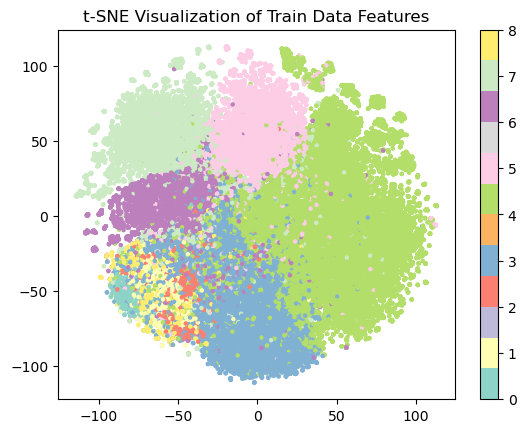

In [51]:
# 可视化
plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=labels_array, cmap='Set3', s=5) 
plt.colorbar()
plt.title("t-SNE Visualization of Train Data Features")
plt.show()

In [52]:
dict = {0: '1653–1705',
 1: '1706–1764',
 2: '1765–1845',
 3: '1846–1910',
 4: '1911–1943',
 5: '1944–1977',
 6: '1978–1994',
 7: '1995–2023',
 8: 'pre-1652'}
# 更换一下标签
# 使用vectorize函数替换labels_array中的值
vfunc = np.vectorize(dict.get)
labels_updated = vfunc(labels_array)
labels_updated

array(['1944–1977', '1995–2023', '1978–1994', ..., '1911–1943',
       '1911–1943', '1765–1845'], dtype='<U9')

In [53]:
import pandas as pd
pd.DataFrame({'1-t':transformed_features[:, 0],
              '2-t':transformed_features[:, 1],
              'label': labels_updated,
                'id': ids_list
}).to_csv('../../data/output/TSNE-output-on-train-datasets.csv', index=False)